# Plate solving

In this tutorial we will plate solve the stack image produced in the [alignment & stacking tutorial](stacking). The way this works is by:
1. Detecting the pixel coordinates of stars in our image.
2. Querying the sky coordinates of stars in the field of view of the image.
3. Compare these two sets to infer the WCS of our image.

```{note}
Step 2. requires the knowledge of the center RA/Dec coordinates and the size of the field of view.
```

Let's load an example image provided by the photutils package.

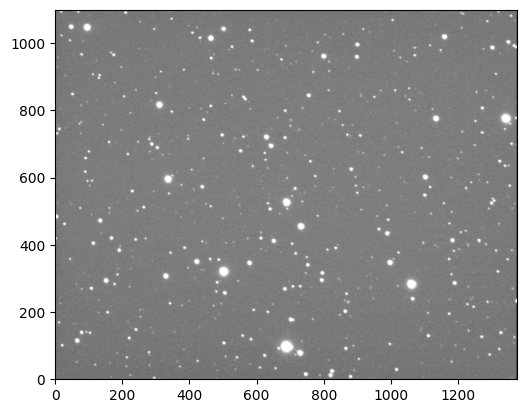

In [1]:
from eloy import viz
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from photutils.datasets import load_star_image
from astropy.io import fits

hdu = fits.open("calibrated_images/stack_image.fits")[0]

_ = plt.imshow(viz.z_scale(hdu.data), cmap="Greys_r", origin="lower")

We start by detecting stars in the image, order them by their total counts on the detector and keep the coordinates of the $n$ brightest.

In [2]:
import numpy as np
from eloy import detection

# detecting stars regions
regions = detection.stars_detection(hdu.data, threshold=20, opening=2)
# sorting by total count
regions = sorted(regions, key=lambda x: x.image_intensity.sum(), reverse=True)
# retrieving n brightest stars coordinates
coords = np.array([r.centroid_weighted[::-1] for r in regions])[0:15]

Here is the image and the detected stars

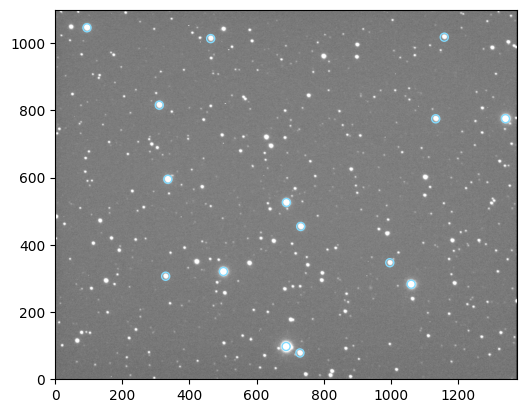

In [3]:
import matplotlib.pyplot as plt

plt.imshow(viz.z_scale(hdu.data), cmap="Greys_r", origin="lower")
viz.plot_marks(*coords.T)

We will now plate solve the image using *twirl*: an asterism-matching algorithm suited for situations where the RA/Dec coordinates of the image and the size of the field-of-view is known.

Let's define the field of view of the image first:

In [4]:
from astropy.coordinates import SkyCoord

# known pixel size in degree
pixel_scale = 0.62 / 3600
# size of the field-of-view
fov = hdu.data.shape[1] * pixel_scale
# RA/Dec coordinates of the image
center = SkyCoord(hdu.header["OBJCTRA"], hdu.header["OBJCTDEC"], unit=("h", "deg"))

*twirl* works by comparing stars detected in the image to stars with known coordinates, for example using a catalog like Gaia. Let's query Gaia stars and build our reference set of stars coordinates

In [5]:
from twirl import gaia_radecs
from twirl.geometry import sparsify

all_radecs = gaia_radecs(
    center,
    1.5 * fov,
)

# we only keep stars 0.01 degree apart from each other
all_radecs = sparsify(all_radecs, 0.01)

We are now ready to compute the WCS. In other words, plate solve our image

In [6]:
from twirl import compute_wcs

# we only use the n brightest stars from gaia
wcs = compute_wcs(coords, all_radecs[0:15], tolerance=10)

To verify that we indeed plate solved our image, we can transform the queried Gaia stars back to pixel coordinates and see if they fall on the stars in the image

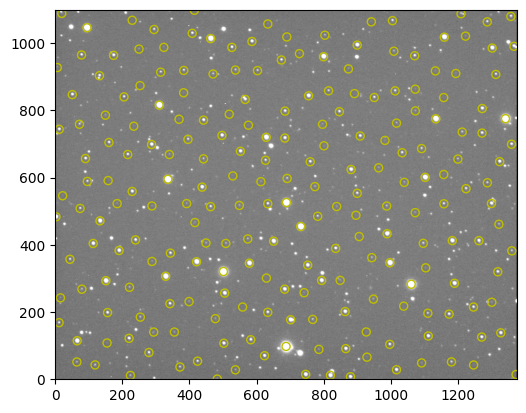

In [7]:
# plotting to check the WCS
radecs_xy = np.array(wcs.world_to_pixel_values(all_radecs))[0:1000]

plt.imshow(viz.z_scale(hdu.data), cmap="Greys_r", origin="lower")
viz.plot_marks(*radecs_xy.T, color="y")

Looks good! For reference, here is the computed WCS

In [8]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 97.70814249327438  29.66839374450852  
CRPIX : 726.6848609619727  580.4381835941349  
CD1_1 CD1_2  : 0.0001594701967799988  3.611110931570882e-06  
CD2_1 CD2_2  : -3.7244302739768004e-06  0.0001594065038107583  
NAXIS : 1341  1046

## Plate solve multiple files

Some stacking algorithms like **Drizzle** require all images to be plate solved with an accurate WCS. Let's plate solve all the calibrated images and save them with their computed WCS

In [9]:
from tqdm.auto import tqdm
from glob import glob

# getting all files
images = glob("calibrated_images/*.fits")


for image in tqdm(images):
    # read image data and header
    data = fits.getdata(image)
    header = fits.getheader(image)

    # detect stars coordinates
    regions = detection.stars_detection(data, threshold=20, opening=2)
    regions = sorted(regions, key=lambda x: x.image_intensity.sum(), reverse=True)
    coords = np.array([r.centroid_weighted[::-1] for r in regions])[0:15]

    # compute WCS
    wcs = compute_wcs(coords, all_radecs[0:15], tolerance=10)

    # save as FITS
    header.update(wcs.to_header())
    hdu = fits.PrimaryHDU(data=data, header=header)
    hdu.writeto(image, overwrite=True)

  0%|          | 0/337 [00:00<?, ?it/s]